#### Example running SpaFHy with jupyter notebook for Pallas catchment(s)

In [1]:
import os
from dotenv import load_dotenv
load_dotenv()
SpaFHy_folder = os.getenv('SPAFHY_V2_FOLDER')
os.chdir(SpaFHy_folder)

from model_driver import parallel_driver
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

###############################################################################
# example parameters to run single catchment or multiple catchments in parallel
catchment = 'pallas' # 'krycklan' / 'pallas' / 'hyytiala'
run_multiple = False # run multiple catchments in parallel (Boolean)
run_one = 2 # run one specific subcatchment (if pallas, 2 = lonmpolonjängänoja)
folder = f'/Users/jpnousu/SpaFHy_RUNS/{catchment}' # input/output directory
###############################################################################

# setting up subcatchments in catchment_no
if run_multiple: # running multiple catchments as in catchment_no
    if catchment == 'pallas':
        catchment_no = np.arange(2,13,1)
    elif catchment == 'krycklan':
        catchment_no = np.arange(1,23,1)
        exclude = [11, 17, 18, 19]
        catchment_no = np.setdiff1d(catchment_no, exclude)
else:
    catchment_no = run_one

outputfile = parallel_driver(catchment, catchment_no, create_ncf=True, create_spinup=False, output=True, folder=folder)

# Reading the .nc results file that was just created
results = xr.open_dataset(outputfile[0])

*** Catchment no.: 2 ***
*** Defined root soil IDs: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17} Used root soil IDs: {2.0, 3.0, 4.0, 7.0, 8.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0} ***
*** Defined organic soil IDs: {0, 1, 2, 3, 4} Used organic soil IDs: {1.0, 2.0, 3.0, 4.0, 5.0} ***
{0.0, 1.0, 2.0, 3.0, 4.0} {1.0, 2.0, 4.0, 5.0}
*** State variables assigned from parameters.py ***
*** Simulation forced with: /Users/jpnousu/SpaFHy_RUNS/pallas/forcing/FORCING.csv
*** Running model ***
*** 2D run
*** Bucket organic layer drains according to Campbell 1985
Running timestep:  1
Timestep: 1 , iterations: 9 , conv1: 0.0007930149093908767 , H[max_index]: -0.009553370180185539
Running timestep:  2


/Users/jpnousu/SpaFHy_v2.0/bucketgrid.py:280: RuntimeWarning: invalid value encountered in power
  Psi = -1 / self.alpha_root*(s**(1.0 / m) - 1.0)**(1.0 / n)  # alpha defines the unit (kPa)


Timestep: 2 , iterations: 14 , conv1: 0.0007538627737062598 , H[max_index]: -0.009559549591529048
Running timestep:  3
Timestep: 3 , iterations: 14 , conv1: 0.0008912375943168627 , H[max_index]: -0.010751315954280471
Running timestep:  4
Timestep: 4 , iterations: 18 , conv1: 0.0007103554146397073 , H[max_index]: -0.010261473490288608
Running timestep:  5
Timestep: 5 , iterations: 19 , conv1: 0.0008224932199141222 , H[max_index]: -0.010012951403723491
Running timestep:  6
Timestep: 6 , iterations: 15 , conv1: 0.0009021724614513005 , H[max_index]: -0.010350989358641982
Running timestep:  7
Timestep: 7 , iterations: 18 , conv1: 0.000642874216225664 , H[max_index]: -0.009289273472802506
Running timestep:  8
Timestep: 8 , iterations: 14 , conv1: 0.0009651942360733301 , H[max_index]: -0.010049012328011031
Running timestep:  9
Timestep: 9 , iterations: 16 , conv1: 0.0008953852885156266 , H[max_index]: -0.01062952733406064
Running timestep:  10
Timestep: 10 , iterations: 16 , conv1: 0.00091647

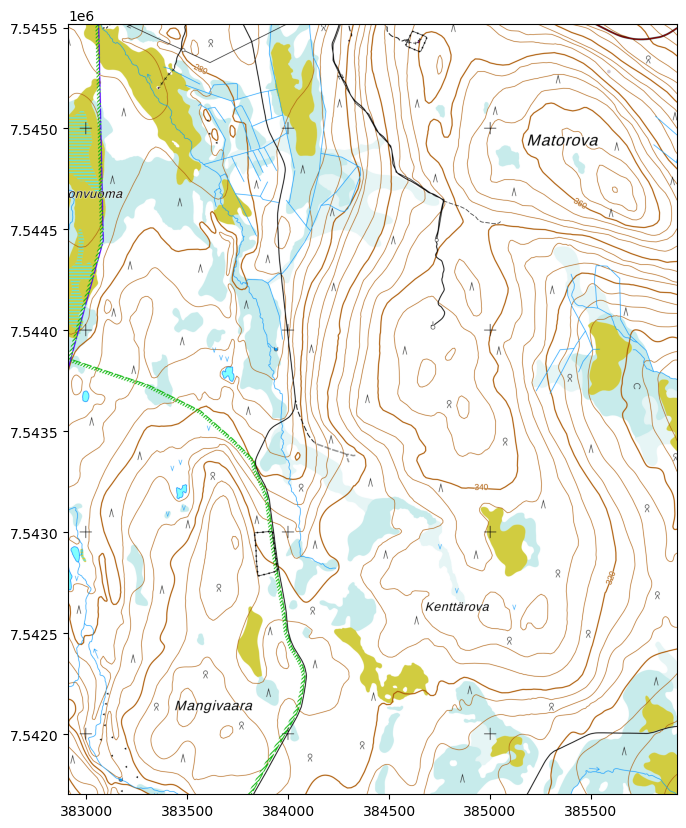

In [30]:
from raster_utils import read_pkrasteri_for_extent
import rasterio

mean = results['deep_netflow_to_ditch'].mean(dim='time')
mean = mean.where(mean != 0, np.nan)
# reading basic map
pkfp = '/Users/jpnousu/SpaFHy_v1_Pallas_2D/testcase_input/parameters/pkmosaic_clipped.tif'
bbox = [results['lon'].min(), results['lon'].max(), results['lat'].min(), results['lat'].max()]
pk, meta = read_pkrasteri_for_extent(pkfp, bbox, showfig=False)

fig, ax = plt.subplots(figsize=(12,10));

rasterio.plot.show(pk, transform=meta['transform'], ax=ax)
#im1 = mean.plot(ax=ax, alpha=1, vmin=0, vmax=40, cmap='RdYlBu')#, add_colorbar=False)
plt.savefig(r'/Users/jpnousu/SpaFHy_RUNS/pallas/notebooks/map.png', dpi=300, bbox_inches='tight')

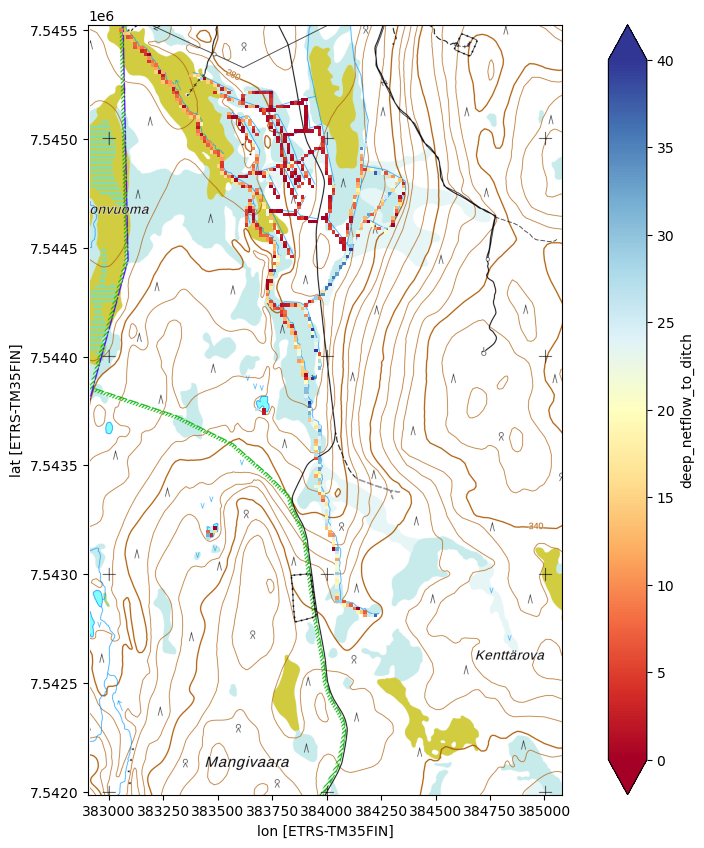

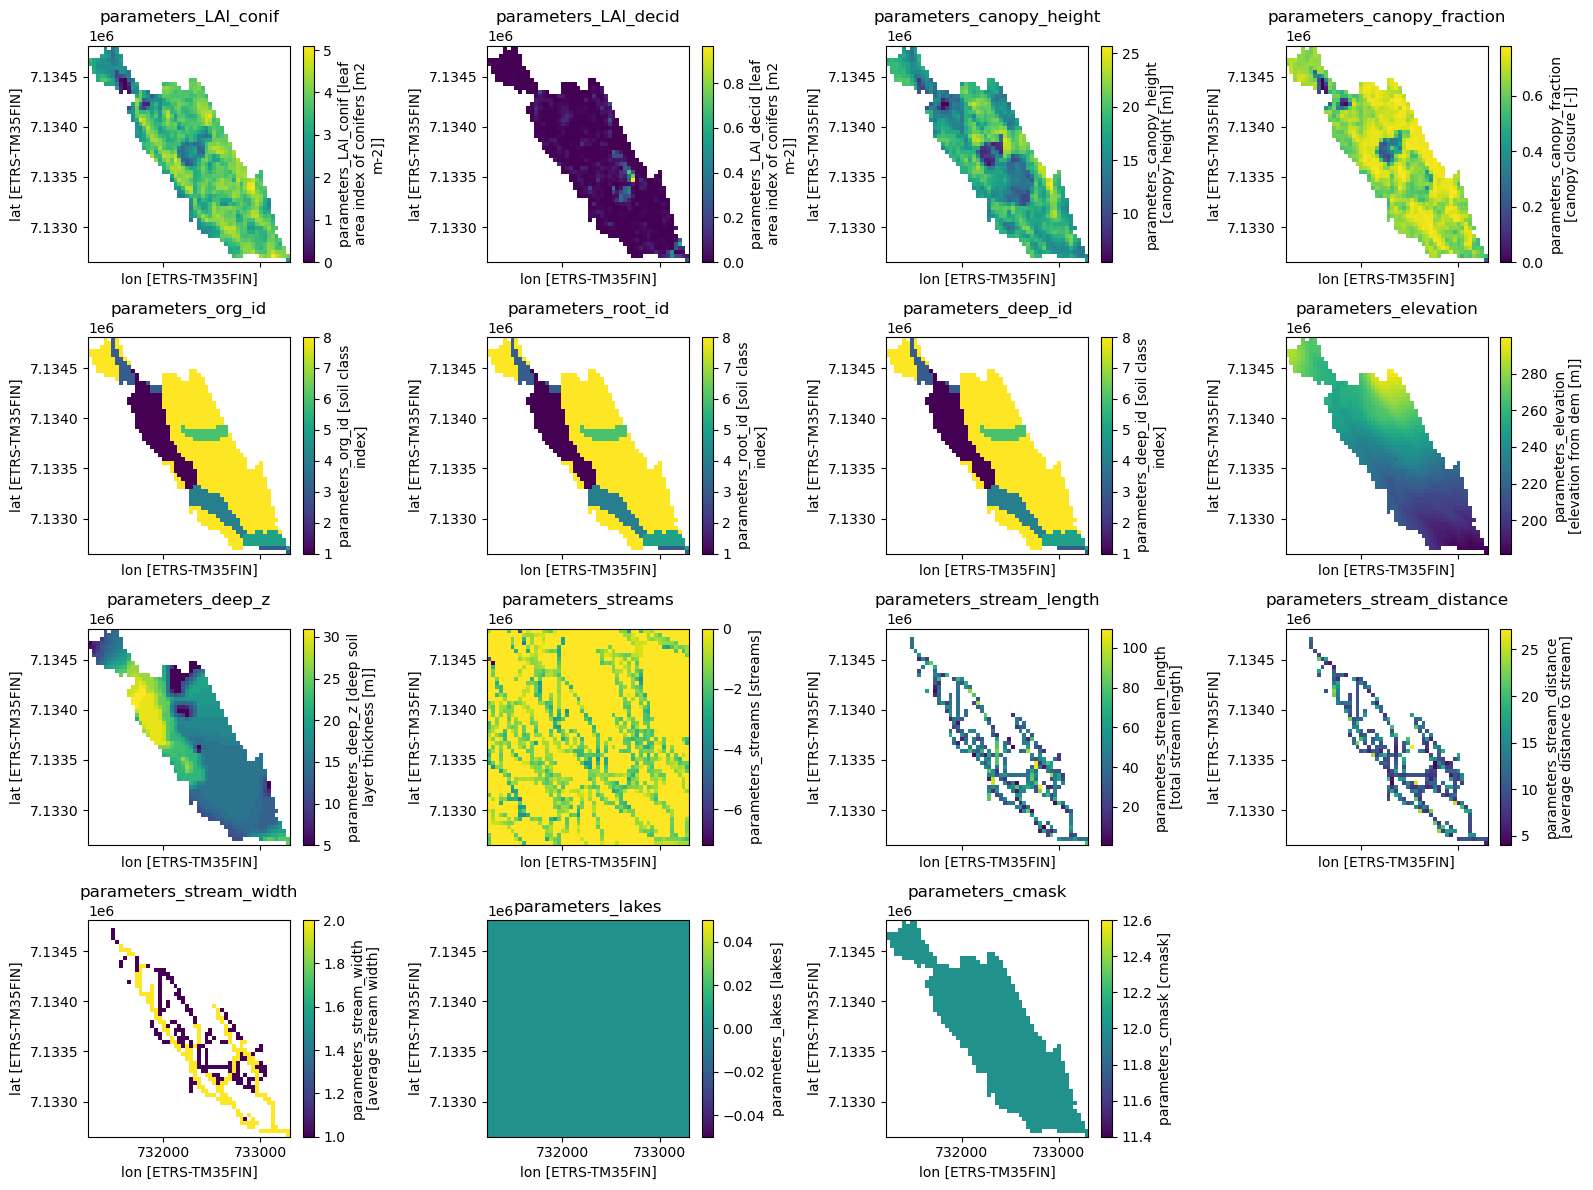

In [2]:
import math

# Collect all keys starting with "parameters_"
param_keys = [k for k in results.keys() if k.startswith("parameters_")]

# Grid setup: 4 columns, rows computed automatically
ncols = 4
nrows = math.ceil(len(param_keys) / ncols)

fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 3*nrows), sharex=True)

axes = axes.flatten()

for ax, key in zip(axes, param_keys):
    results[key].plot(ax=ax)
    ax.set_title(key)

for ax in axes[len(param_keys):]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()


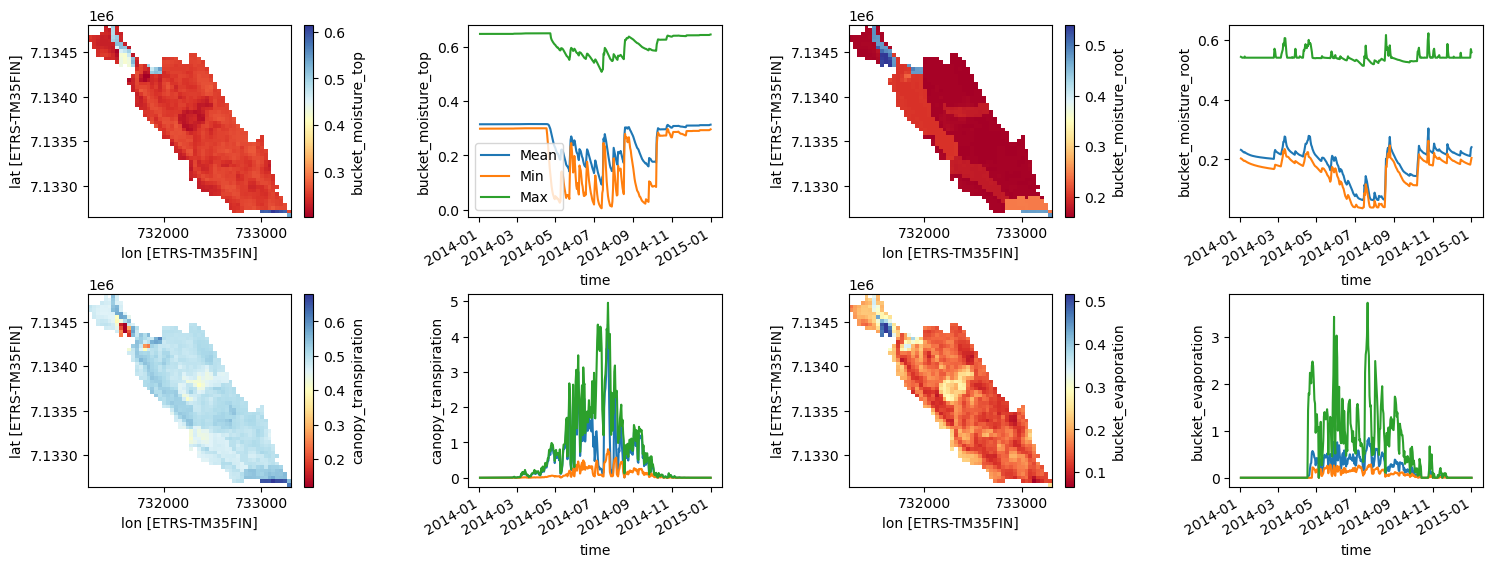

In [3]:
# example plot 1 (works for 1D, TOP, or 2D simulation)

fig, axes = plt.subplots(2, 4, figsize=(18, 6))  # 2 rows, 4 columns
axes = axes.flatten()  # Flatten to easily index 0–7

# Plot 1
results['bucket_moisture_top'].mean(dim='time').plot(ax=axes[0], cmap='RdYlBu')

# Plot 2
results['bucket_moisture_top'].mean(dim=['lat', 'lon']).plot(ax=axes[1], label='Mean')
results['bucket_moisture_top'].min(dim=['lat', 'lon']).plot(ax=axes[1], label='Min')
results['bucket_moisture_top'].max(dim=['lat', 'lon']).plot(ax=axes[1], label='Max')
axes[1].legend()
# Plot 3
results['bucket_moisture_root'].mean(dim='time').plot(ax=axes[2], cmap='RdYlBu')

# Plot 4
results['bucket_moisture_root'].mean(dim=['lat', 'lon']).plot(ax=axes[3], label='Mean')
results['bucket_moisture_root'].min(dim=['lat', 'lon']).plot(ax=axes[3], label='Min')
results['bucket_moisture_root'].max(dim=['lat', 'lon']).plot(ax=axes[3], label='Max')

# Plot 5
results['canopy_transpiration'].mean(dim='time').plot(ax=axes[4], cmap='RdYlBu')

# Plot 6
results['canopy_transpiration'].mean(dim=['lat', 'lon']).plot(ax=axes[5], label='Mean')
results['canopy_transpiration'].min(dim=['lat', 'lon']).plot(ax=axes[5], label='Min')
results['canopy_transpiration'].max(dim=['lat', 'lon']).plot(ax=axes[5], label='Max')

# Plot 7
results['bucket_evaporation'].mean(dim='time').plot(ax=axes[6], cmap='RdYlBu')

# Plot 8
results['bucket_evaporation'].mean(dim=['lat', 'lon']).plot(ax=axes[7], label='Mean')
results['bucket_evaporation'].min(dim=['lat', 'lon']).plot(ax=axes[7], label='Min')
results['bucket_evaporation'].max(dim=['lat', 'lon']).plot(ax=axes[7], label='Max')

# Plot 8
#results['parameters_streams'].plot(ax=axes[7])

plt.subplots_adjust(wspace=0.5, hspace=0.4)  # Adjust spacing between plots

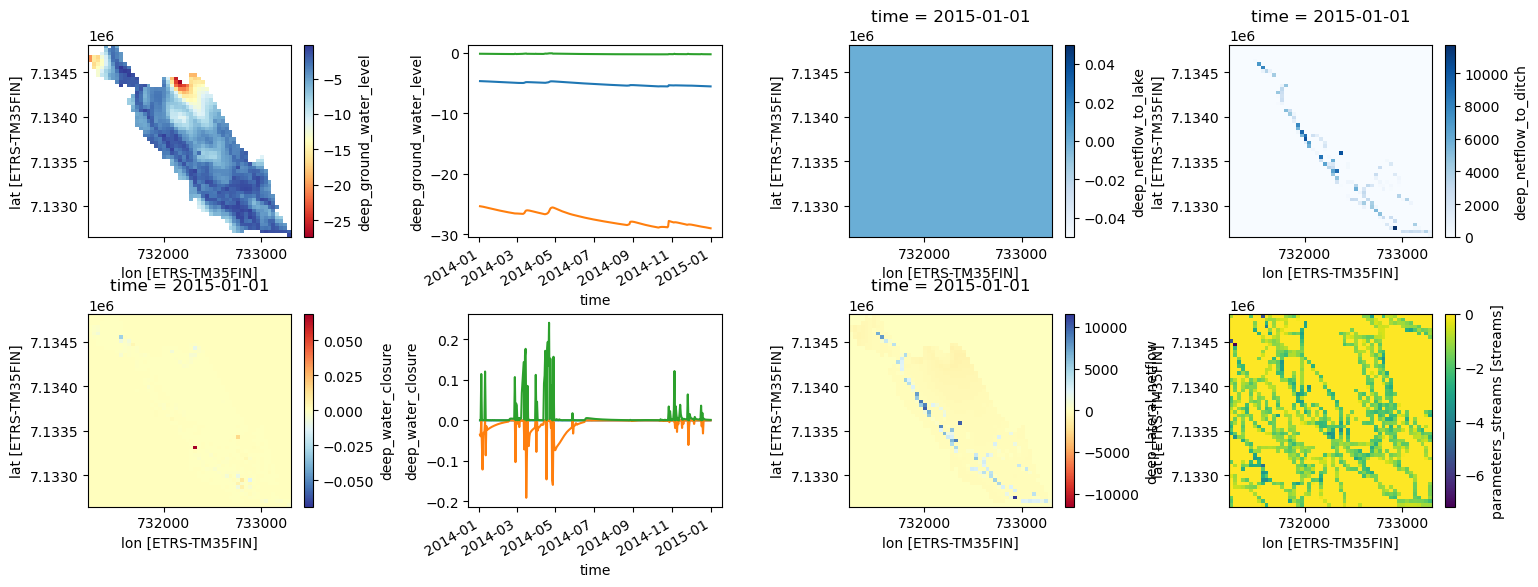

In [4]:
# example plot 2 (works only for 2D simulation)

fig, axes = plt.subplots(2, 4, figsize=(18, 6))  # 2 rows, 4 columns
axes = axes.flatten()  # Flatten to easily index 0–7

# Plot 1
results['deep_ground_water_level'].mean(dim='time').plot(ax=axes[0], cmap='RdYlBu')

# Plot 2
results['deep_ground_water_level'].mean(dim=['lat', 'lon']).plot(ax=axes[1], label='Mean')
results['deep_ground_water_level'].min(dim=['lat', 'lon']).plot(ax=axes[1], label='Min')
results['deep_ground_water_level'].max(dim=['lat', 'lon']).plot(ax=axes[1], label='Max')

# Plot 3
results['deep_netflow_to_lake'].cumsum(dim='time')[-1].plot(ax=axes[2], cmap='Blues')

# Plot 4
#results['deep_netflow_to_ditch'][0].plot(ax=axes[3])
results['deep_netflow_to_ditch'].cumsum(dim='time')[-1].plot(ax=axes[3], cmap='Blues')

# Plot 5
#results['deep_water_closure'][-1].plot(ax=axes[4])
results['deep_water_closure'].cumsum(dim='time')[-1].plot(ax=axes[4], cmap='RdYlBu_r')

# Plot 6
results['deep_water_closure'].mean(dim=['lat', 'lon']).plot(ax=axes[5], label='Mean')
results['deep_water_closure'].min(dim=['lat', 'lon']).plot(ax=axes[5], label='Min')
results['deep_water_closure'].max(dim=['lat', 'lon']).plot(ax=axes[5], label='Max')

# Plot 7
#results['deep_lateral_netflow'].min(dim='time').plot(ax=axes[6])
results['deep_lateral_netflow'].cumsum(dim='time')[-1].plot(ax=axes[6], cmap='RdYlBu')

# Plot 8
results['parameters_streams'].plot(ax=axes[7])

plt.subplots_adjust(wspace=0.5, hspace=0.4)  # Adjust spacing between plots

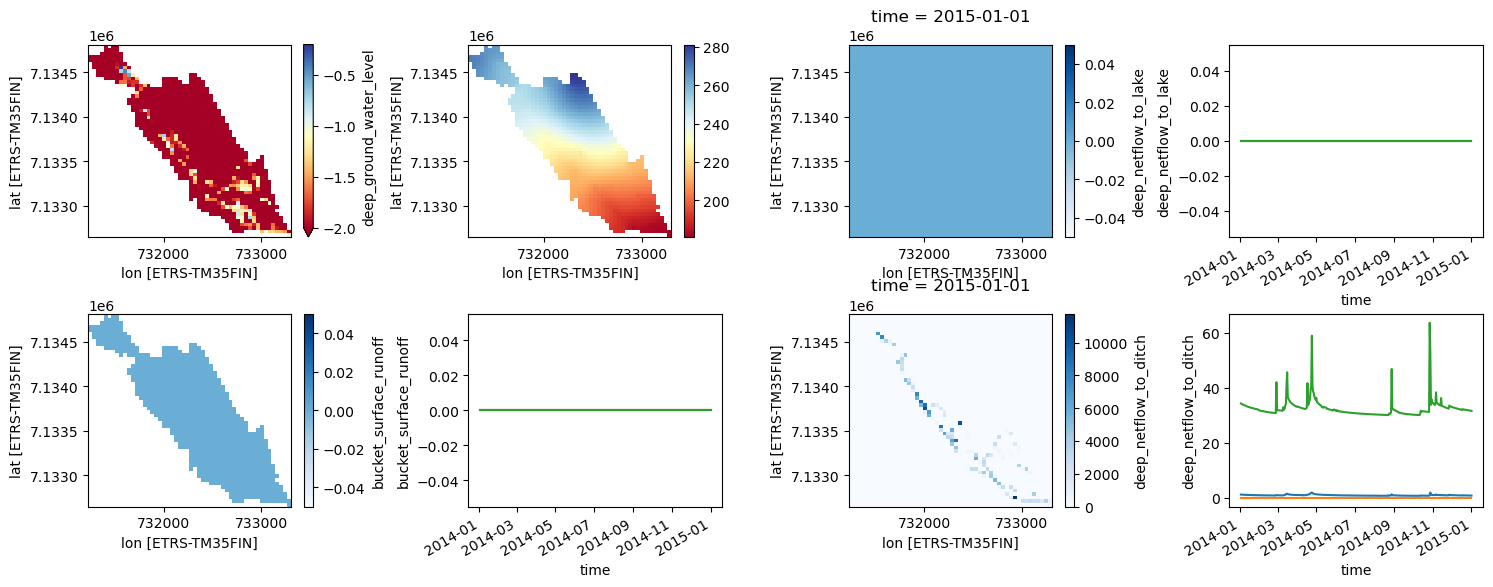

In [5]:
# example plot 2 (works only for 2D simulation)

fig, axes = plt.subplots(2, 4, figsize=(18, 6))  # 2 rows, 4 columns
axes = axes.flatten()  # Flatten to easily index 0–7

# Plot 1
results['deep_ground_water_level'].mean(dim='time').plot(ax=axes[0], vmin=-2., cmap='RdYlBu')

# Plot 2
(results['parameters_elevation'] + results['deep_ground_water_level'].mean(dim='time')).plot(ax=axes[1], cmap='RdYlBu')


# Plot 3
results['deep_netflow_to_lake'].cumsum(dim='time')[-1].plot(ax=axes[2], cmap='Blues')

# Plot 4
#results['deep_netflow_to_ditch'][0].plot(ax=axes[3])
results['deep_netflow_to_lake'].mean(dim=['lat', 'lon']).plot(ax=axes[3], label='Mean')
results['deep_netflow_to_lake'].min(dim=['lat', 'lon']).plot(ax=axes[3], label='Min')
results['deep_netflow_to_lake'].max(dim=['lat', 'lon']).plot(ax=axes[3], label='Max')

# Plot 5
#results['deep_water_closure'][-1].plot(ax=axes[4])
results['bucket_surface_runoff'].mean(dim='time').plot(ax=axes[4], cmap='Blues')

# Plot 6
results['bucket_surface_runoff'].mean(dim=['lat', 'lon']).plot(ax=axes[5], label='Mean')
results['bucket_surface_runoff'].min(dim=['lat', 'lon']).plot(ax=axes[5], label='Min')
results['bucket_surface_runoff'].max(dim=['lat', 'lon']).plot(ax=axes[5], label='Max')

# Plot 7
#results['deep_lateral_netflow'].min(dim='time').plot(ax=axes[6])
results['deep_netflow_to_ditch'].cumsum(dim='time')[-1].plot(ax=axes[6], cmap='Blues')

# Plot 8
results['deep_netflow_to_ditch'].mean(dim=['lat', 'lon']).plot(ax=axes[7], label='Mean')
results['deep_netflow_to_ditch'].min(dim=['lat', 'lon']).plot(ax=axes[7], label='Min')
results['deep_netflow_to_ditch'].max(dim=['lat', 'lon']).plot(ax=axes[7], label='Max')

plt.subplots_adjust(wspace=0.5, hspace=0.4)  # Adjust spacing between plots

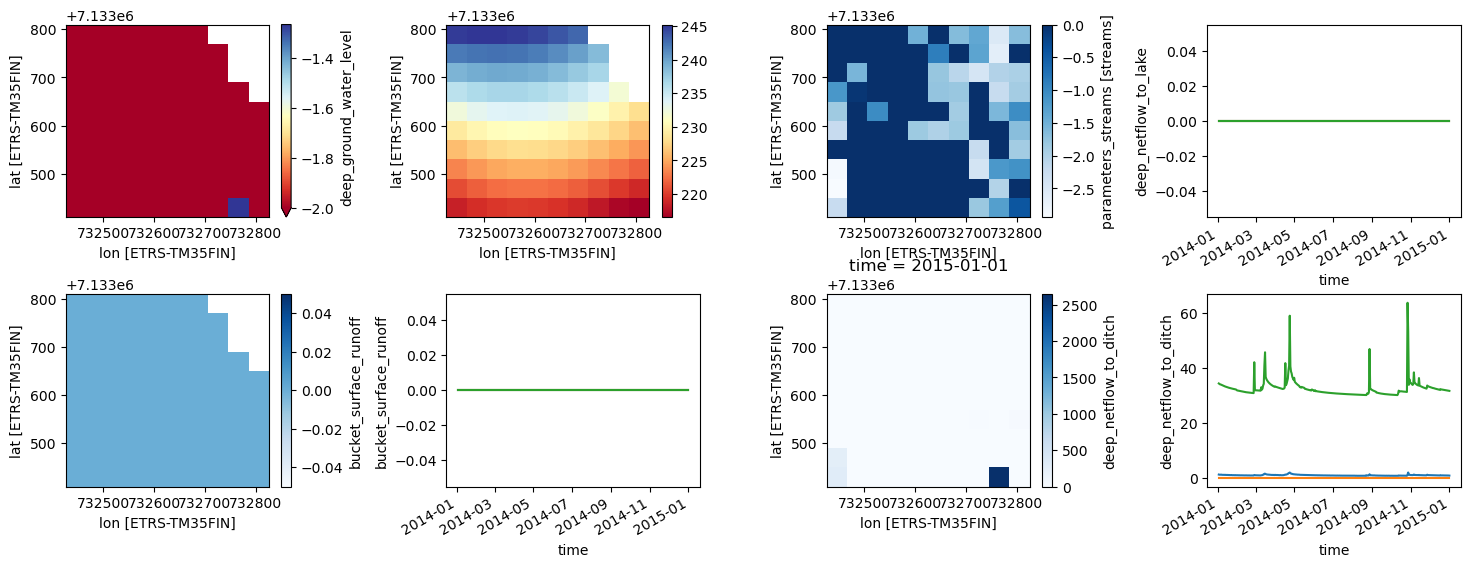

In [6]:
# example plot 2 (works only for 2D simulation)

row_slice = slice(25, 35)
col_slice = slice(30, 40)

fig, axes = plt.subplots(2, 4, figsize=(18, 6))  # 2 rows, 4 columns
axes = axes.flatten()  # Flatten to easily index 0–7

# Plot 1
results['deep_ground_water_level'].mean(dim='time')[row_slice,col_slice].plot(ax=axes[0], vmin=-2., cmap='RdYlBu')

# Plot 2
(results['parameters_elevation'][row_slice, col_slice] + results['deep_ground_water_level'].mean(dim='time')[row_slice, col_slice]).plot(ax=axes[1], cmap='RdYlBu')


# Plot 3
results['parameters_streams'][row_slice, col_slice].plot(ax=axes[2], cmap='Blues')

# Plot 4
#results['deep_netflow_to_ditch'][0].plot(ax=axes[3])
results['deep_netflow_to_lake'].mean(dim=['lat', 'lon']).plot(ax=axes[3], label='Mean')
results['deep_netflow_to_lake'].min(dim=['lat', 'lon']).plot(ax=axes[3], label='Min')
results['deep_netflow_to_lake'].max(dim=['lat', 'lon']).plot(ax=axes[3], label='Max')

# Plot 5
#results['deep_water_closure'][-1].plot(ax=axes[4])
results['bucket_surface_runoff'].mean(dim='time')[row_slice,col_slice].plot(ax=axes[4], cmap='Blues')

# Plot 6
results['bucket_surface_runoff'].mean(dim=['lat', 'lon']).plot(ax=axes[5], label='Mean')
results['bucket_surface_runoff'].min(dim=['lat', 'lon']).plot(ax=axes[5], label='Min')
results['bucket_surface_runoff'].max(dim=['lat', 'lon']).plot(ax=axes[5], label='Max')

# Plot 7
#results['deep_lateral_netflow'].min(dim='time').plot(ax=axes[6])
results['deep_netflow_to_ditch'].cumsum(dim='time')[-1,row_slice, col_slice].plot(ax=axes[6], cmap='Blues')

# Plot 8
results['deep_netflow_to_ditch'].mean(dim=['lat', 'lon']).plot(ax=axes[7], label='Mean')
results['deep_netflow_to_ditch'].min(dim=['lat', 'lon']).plot(ax=axes[7], label='Min')
results['deep_netflow_to_ditch'].max(dim=['lat', 'lon']).plot(ax=axes[7], label='Max')

plt.subplots_adjust(wspace=0.5, hspace=0.4)  # Adjust spacing between plots

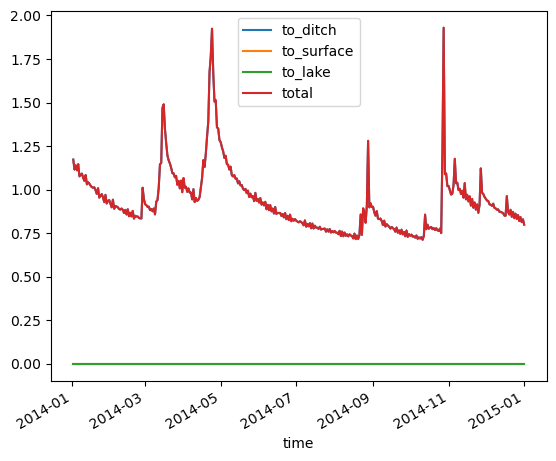

In [7]:
results['deep_netflow_to_ditch'].mean(dim=['lat','lon']).plot(label='to_ditch')
results['bucket_surface_runoff'].mean(dim=['lat','lon']).plot(label='to_surface')
results['deep_netflow_to_lake'].mean(dim=['lat','lon']).plot(label='to_lake')
(results['deep_netflow_to_ditch'].mean(dim=['lat','lon']) + 
 results['bucket_surface_runoff'].mean(dim=['lat','lon']) + 
 results['deep_netflow_to_lake'].mean(dim=['lat','lon'])).plot(label='total')
plt.legend()